In [1]:
import numpy as np
from qutip import Options
import qutip as qt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.hamiltonian import QubitQubitCavity
from quantum_logical.pulsesim.mode import QubitMode, CavityMode

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [2]:
# Optionally, can build from a YAML file instead :)
# quantum_system = QuantumSystem.from_yaml(yaml_file)

# FIXME, these kwargs attributes are ugly/bad :(
qubit1 = QubitMode(mode_type="Qubit", name="q1", dim=2, freq=2.0, alpha=-0.1)
qubit2 = QubitMode(mode_type="Qubit", name="q2", dim=2, freq=3.0, alpha=-0.1)
cavity = CavityMode(mode_type="Cavity", name="c", dim=2, freq=5.0)
_couplings = {(qubit1, cavity): 2 * np.pi * 0.01, (qubit2, cavity): 2 * np.pi * 0.0125}

quantum_system = QuantumSystem([qubit1, qubit2, cavity], couplings=_couplings)

In [3]:
hamiltonian = QubitQubitCavity(quantum_system)
hamiltonian.H  # non-interacting hamiltonian

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 15.70796327   0.           0.           0.           0.
    0.           0.           0.        ]
 [  0.          47.1238898    0.           0.           0.
    0.           0.           0.        ]
 [  0.           0.          -3.14159265   0.           0.
    0.           0.           0.        ]
 [  0.           0.           0.          28.27433388   0.
    0.           0.           0.        ]
 [  0.           0.           0.           0.           3.14159265
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   34.55751919   0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         -15.70796327   0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.          15.70796327]]

In [4]:
# prepare an initial state
psi0 = quantum_system.prepare_tensor_fock_state([(qubit1, 1)])

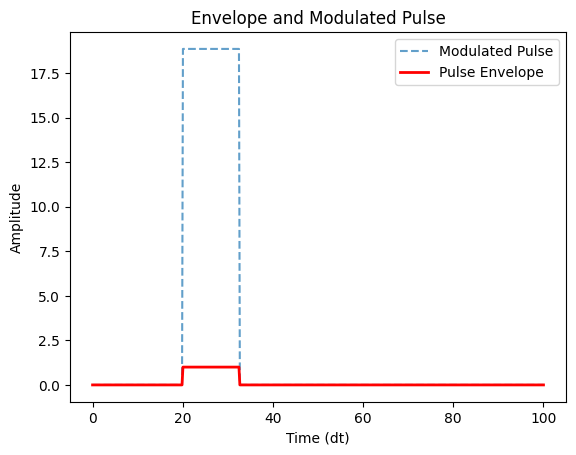

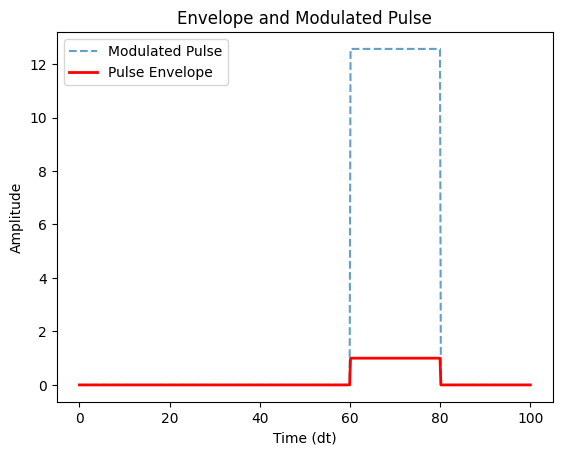

In [5]:
width_d1 = np.pi / (4 * quantum_system.couplings[(qubit1, cavity)])
width_d2 = 2 * np.pi / (4 * quantum_system.couplings[(qubit2, cavity)])

args1 = {"shape": Pulse.box, "shape_params": {"t0": 20, "width": width_d1}}
pulse1 = Pulse(omega=0.0, amp=np.abs(qubit1.freq - cavity.freq))
lambda_pulse1 = lambda t, args: pulse1.drive(t, args1)

args2 = {"shape": Pulse.box, "shape_params": {"t0": 60, "width": width_d2}}
pulse2 = Pulse(omega=0.0, amp=np.abs(qubit2.freq - cavity.freq))
lambda_pulse2 = lambda t, args: pulse2.drive(t, args2)

# plot an example pulse from the experiment to verify its shape
t_list = np.linspace(0, 100, 500)
pulse1.plot_pulse(args1["shape"], t_list, **args1["shape_params"])
pulse2.plot_pulse(args2["shape"], t_list, **args2["shape_params"])

In [6]:
# create list of time-dependent Hamiltonian terms
H = hamiltonian.driven(lambda_pulse1, lambda_pulse2)

result = qt.mesolve(
    H,
    psi0,
    t_list,
    e_ops=[
        quantum_system.modes_num[qubit1],
        quantum_system.modes_num[qubit2],
        quantum_system.modes_num[cavity],
    ],
    progress_bar=p_bar,
)

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.16s. Est. time left: 00:00:00:00
40.0%. Run time:   0.20s. Est. time left: 00:00:00:00
50.0%. Run time:   0.25s. Est. time left: 00:00:00:00
60.0%. Run time:   0.30s. Est. time left: 00:00:00:00
70.0%. Run time:   0.35s. Est. time left: 00:00:00:00
80.0%. Run time:   0.40s. Est. time left: 00:00:00:00
90.0%. Run time:   0.44s. Est. time left: 00:00:00:00
Total run time:   0.49s


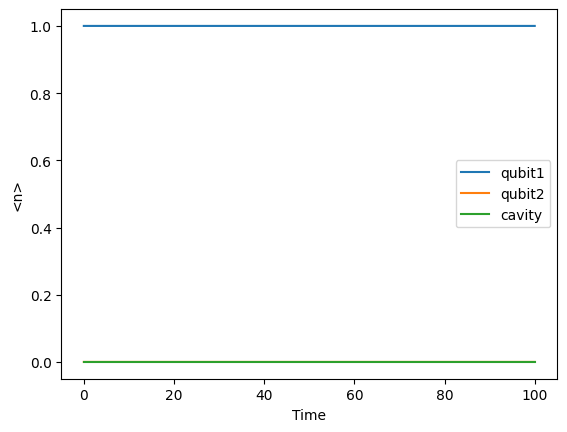

In [7]:
# plot time-series data, for expectation values of the 3 modes
qubit1_num = result.expect[0]
qubit2_num = result.expect[1]
cavity_num = result.expect[2]

import matplotlib.pyplot as plt

plt.plot(t_list, qubit1_num, label="qubit1")
plt.plot(t_list, qubit2_num, label="qubit2")
plt.plot(t_list, cavity_num, label="cavity")

plt.xlabel("Time")
plt.ylabel("<n>")

plt.legend()
plt.show()